## This notebook's main goals (rudimentary pipeline)
1. to extract DLC .h5 data into a dataframe
2. analyze the time mouse spent in each shelter for sepcific body parts

In [57]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py

In [79]:
#Read in the DLC output
h5_file_path = "/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119976_shuffle1_400000.h5"  
# h5_file_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119623_shuffle1_100000.h5'
#this is from mouse-id 1119976
dataframe = pd.read_hdf(h5_file_path)

#Read in the shelter ROIs
shelter_coords_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119976_shelter_coords.npy'
# shelter_coords_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119623_shelter_coords.npy'
shelter_coords = np.load(shelter_coords_path)

In [80]:
import pandas as pd
import logging

class DLCTrackingDataProcessor:
    def __init__(self):
        self.dlc_output = {}
        self.tracking_data_body_parts = {}
        self.dlc_network_name = ''
        self.logger = logging.getLogger(__name__)

    def extract_data_from_dlc_file(self, dataframe, body_parts, scorer) -> None:
        """
        Processes data from a DataFrame outputted from DLC analysis.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the tracking data.
            body_parts (list): List of body parts to track.
            scorer (str): Name of the scorer.
        """

        for body_part in body_parts:
            self.dlc_output[body_part] = {
                'x': dataframe[scorer, body_part, 'x'],
                'y': dataframe[scorer, body_part, 'y'],
                'likelihood': dataframe[scorer, body_part, 'likelihood']
            }

        self.tracking_data_body_parts['bodyparts'] = body_parts
        self.logger.info(f"The bodyparts tracked by DLC are: {self.tracking_data_body_parts['bodyparts']}")

In [82]:
body_parts = ['nose', 'headcenter', 'neck', 'rightear', 'leftear', 'lefthip', 'righthip', 'leftside', 'rightside', 'bodycenter', 'tailbase', 't1', 't2']
scorer = dataframe.columns[0][0]
processor = DLCTrackingDataProcessor()
processor.extract_data_from_dlc_file(dataframe, body_parts,scorer)

In [75]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as mpath
import numpy as np


####################################Function realated to ROIs####################################

# Function to draw the ROI on the plot as a polygon
def draw_roi(ax, roi_points, color, label):
    poly = patches.Polygon(roi_points, linewidth=6, edgecolor=color, facecolor='none', closed=True,zorder=5)
    ax.add_patch(poly)
    # Place the label at the centroid of the polygon
    centroid = np.mean(roi_points, axis=0)
    ax.text(centroid[0], centroid[1], label, color=color, ha='center', va='center',size=20)

def is_inside_roi(point, roi_points):
    """
    Check if a point is inside a given ROI (polygon).
    """
    path = mpath.Path(roi_points)
    return path.contains_point(point)

def calculate_time_in_ROIs(dataframe, start_frame, ROIs, fps, bodypart):
    time_in_ROIs = {key: 0 for key in ROIs}
    scorer = dataframe.columns[0][0]  # Extract the scorer name from the DataFrame

    for i in range(start_frame, len(dataframe)):
        # Access x and y coordinates using the MultiIndex
        x_coord = dataframe[scorer, bodypart, 'x'].iloc[i]
        y_coord = dataframe[scorer, bodypart, 'y'].iloc[i]
        point = (x_coord, y_coord)

        for roi_key, roi in ROIs.items():
            if is_inside_roi(point, roi):
                time_in_ROIs[roi_key] += 1
    
    return {key: value / fps for key, value in time_in_ROIs.items()}

####################################Function realated to plotting####################################
def PlottingResults(Dataframe, bodyparts2plot, ROIs, alphavalue=.2, pcutoff=.5, colormap='jet', fs=(10,10)):
    plt.figure(figsize=fs)
    scorer = Dataframe.columns[0][0]
    colors = plt.cm.get_cmap(colormap, len(bodyparts2plot))
    ax = plt.gca()

    for bpindex, bp in enumerate(bodyparts2plot):
        Index = Dataframe[scorer][bp]['likelihood'].values > pcutoff
        ax.plot(Dataframe[scorer][bp]['x'].values[Index], 
                Dataframe[scorer][bp]['y'].values[Index], 
                '.', 
                color=colors(bpindex), 
                alpha=alphavalue, 
                label=bp)
    
    # Draw each shelter ROI
    shelter_colors = ['r', 'g', 'b']  # Different color for each shelter
    for i, (roi_key, roi_points) in enumerate(ROIs.items()):
        draw_roi(ax, roi_points, shelter_colors[i], roi_key)

    # Reverse the y-axis to match the image coordinate system
    ax.invert_yaxis()

    # Adjust plot limits if needed
    plt.xlim([Dataframe[scorer][bodyparts2plot[0]]['x'].min(), Dataframe[scorer][bodyparts2plot[0]]['x'].max()])
    plt.ylim([Dataframe[scorer][bodyparts2plot[0]]['y'].max(), Dataframe[scorer][bodyparts2plot[0]]['y'].min()])

    
    # Adding legend
    plt.legend()

    # Optionally, add titles and labels
    plt.title("Tracking Results")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

    plt.show()


/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_58299/2990696170.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, len(bodyparts2plot))


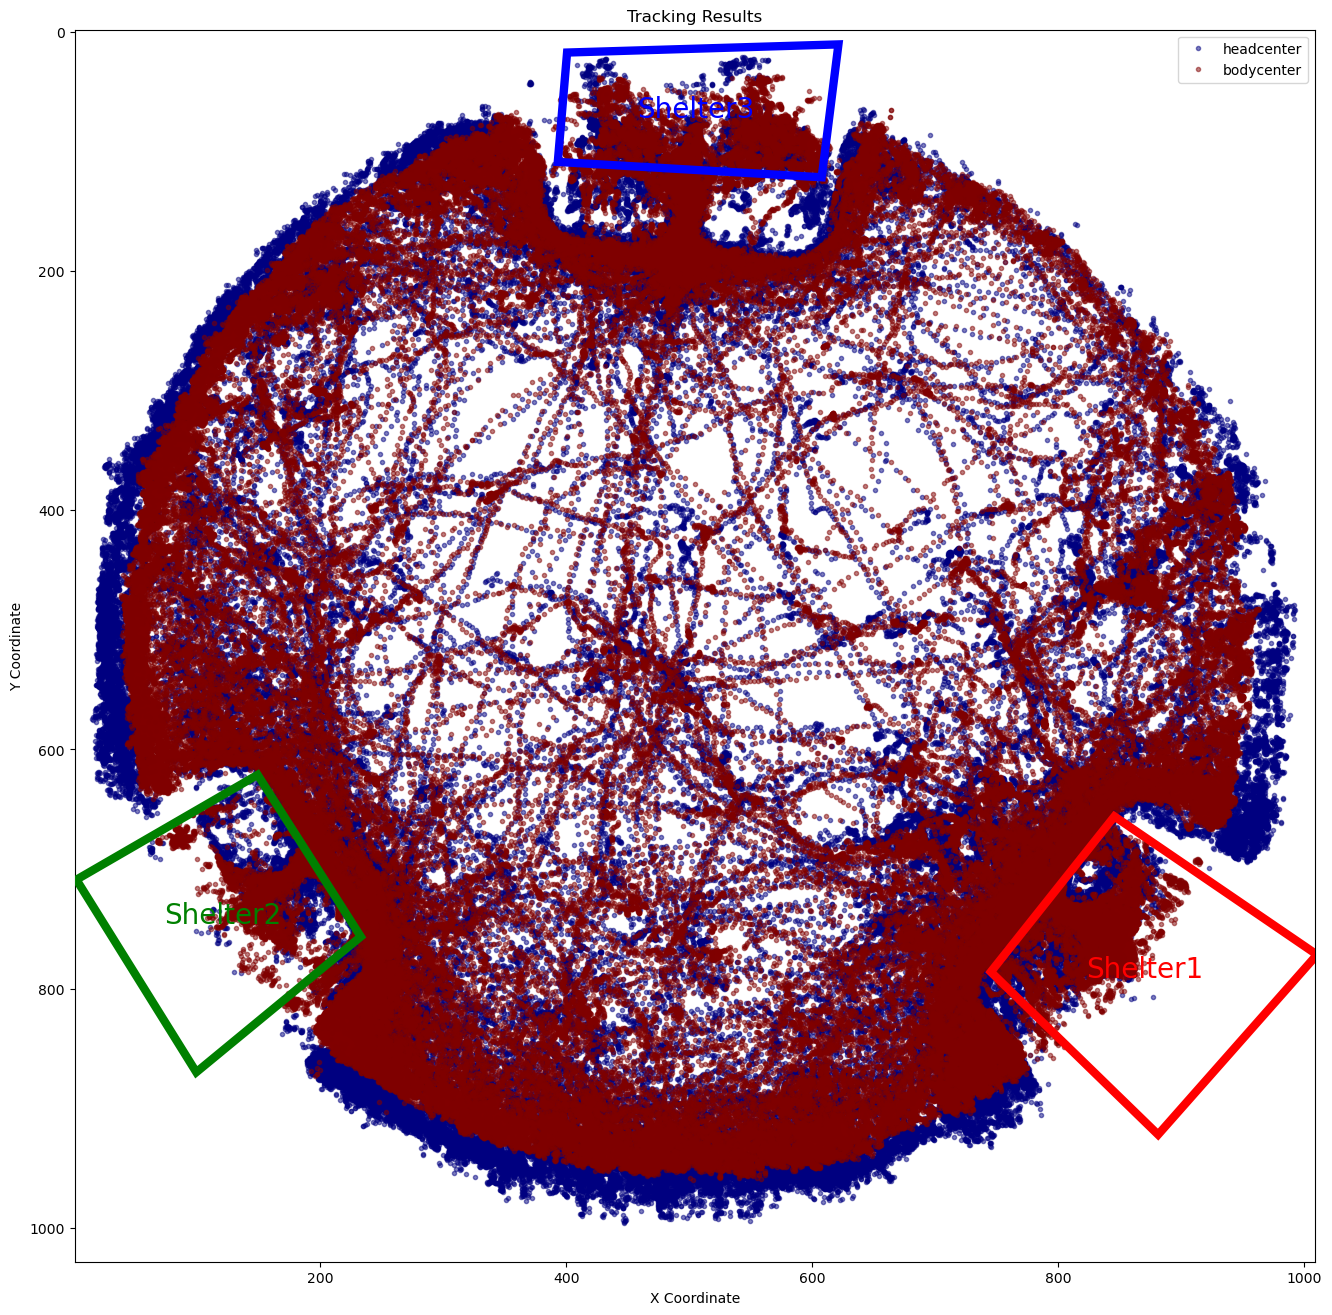

Time (seconds) in ROIs for headcenter: {'Shelter1': 737.675, 'Shelter2': 448.425, 'Shelter3': 792.625}
Time (seconds) in ROIs for bodycenter: {'Shelter1': 726.65, 'Shelter2': 397.65, 'Shelter3': 797.575}


In [85]:
# Usage example
bodyparts2plot = ['nose', 'headcenter', 'neck', 'rightear', 'leftear', 'lefthip', 'righthip', 'leftside', 'rightside', 'bodycenter', 'tailbase', 't1', 't2ss']

bodyparts2plot=['headcenter','bodycenter']

ROIs = {
    'Shelter1': shelter_coords[0:4],
    'Shelter2': shelter_coords[4:8],
    'Shelter3': shelter_coords[8:12]
}

#frame starts at 4005 for 1119623
#frame starts at 6559 for 1119976

PlottingResults(dataframe[6559 * 40:], bodyparts2plot, ROIs, alphavalue=0.5, pcutoff=.5,fs=(16,16))

# Calculate time in ROIs
fps = 40  # Adjust as needed
for bodypart in bodyparts2plot:
    time_in_rois = calculate_time_in_ROIs(dataframe, start_frame=0, ROIs=ROIs, fps=fps, bodypart=bodypart)
    print(f"Time (seconds) in ROIs for {bodypart}:", time_in_rois)

/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_58299/2990696170.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, len(bodyparts2plot))


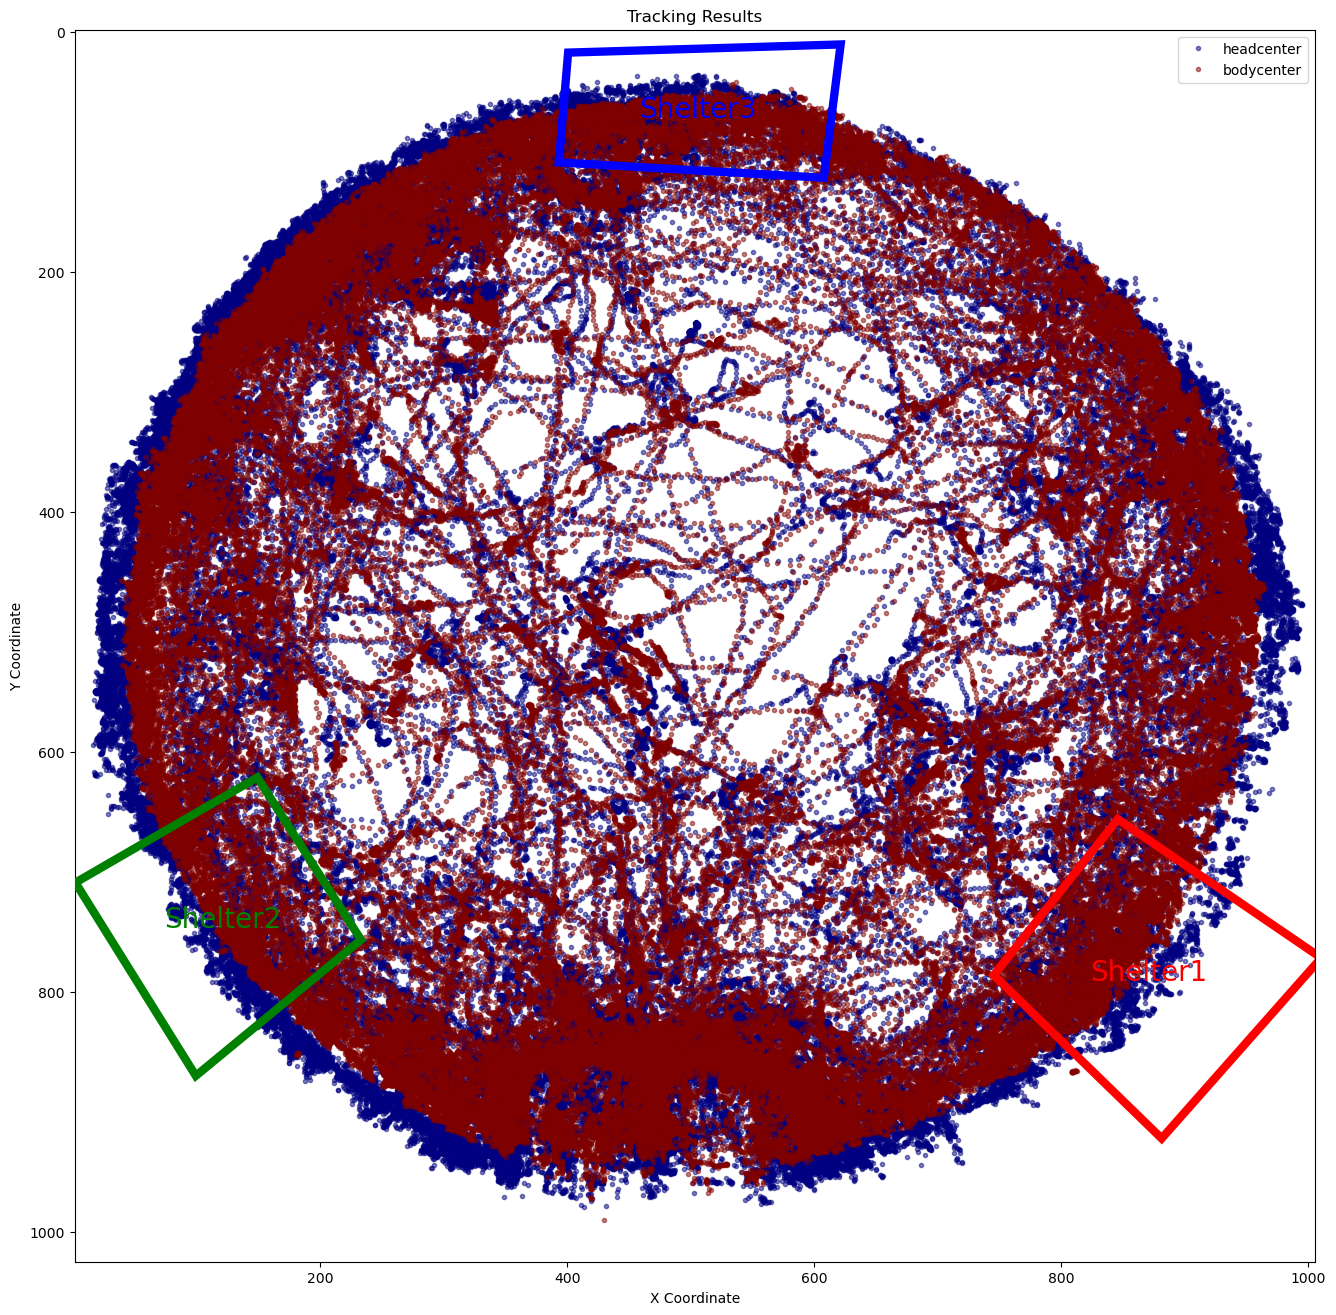

Time (seconds) in ROIs for headcenter: {'Shelter1': 737.675, 'Shelter2': 448.425, 'Shelter3': 792.625}
Time (seconds) in ROIs for bodycenter: {'Shelter1': 726.65, 'Shelter2': 397.65, 'Shelter3': 797.575}


In [86]:
#hopefully we see a trend that before the multi_shelter session they also spend less time in shelter 2 area 
PlottingResults(dataframe[:6559 * 40], bodyparts2plot, ROIs, alphavalue=0.5, pcutoff=.5,fs=(16,16))

# Calculate time in ROIs
fps = 40  # Adjust as needed
for bodypart in bodyparts2plot:
    time_in_rois = calculate_time_in_ROIs(dataframe, start_frame=0, ROIs=ROIs, fps=fps, bodypart=bodypart)
    print(f"Time (seconds) in ROIs for {bodypart}:", time_in_rois)